We import some parts from qiskit library and other libraries.

In [25]:
from qiskit import *
from qiskit import IBMQ
from qiskit import Aer
import numpy as np
import matplotlib.pyplot as plt
import statistics as st
import scipy.optimize as sci
from scipy.interpolate import interp1d as imp
from qiskit.tools.visualization import plot_bloch_multivector
from qiskit.tools.visualization import plot_histogram

we get simulators, we now have a quantum simulator, a satevector simulator and a simulator of IBM's cloud quantum machine.

In [26]:
simulator = Aer.get_backend('qasm_simulator')
statecomp = Aer.get_backend('statevector_simulator')
# IBMQ.load_account()
# provider = IBMQ.get_provider('ibm-q')
# qcomp= provider.get_backend('ibmq_qasm_simulator')

We now make our bits and basic circuit with measurement of qbit to realise it .

c:\Users\ishaa\AppData\Local\Programs\Python\Python39\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


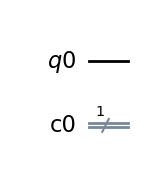

In [27]:
qbit = QuantumRegister(1,name='q0')
cbit = ClassicalRegister(1,name='c0')
qc = QuantumCircuit(qbit,cbit)
qc.draw('mpl')

We simulate our circuit with statevector simulator and present the qbit in bloch sphere.

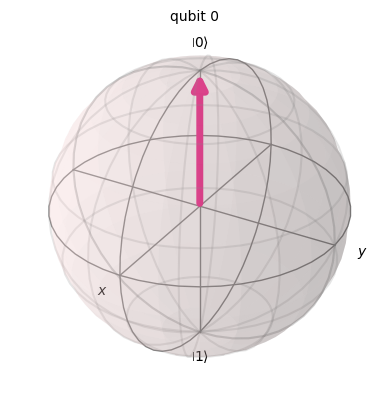

In [28]:
results = execute(qc, backend= statecomp).result()
statevector = results.get_statevector()
plot_bloch_multivector(statevector)

We rotate the qbit by $\theta$ angle along an axis say y-axis and then measure the probability of the statevector in computational basis states $ |0> $ and $|1>$ .
The rotation operator is $e^{-i\sigma_y\frac{\theta}{2}}|0⟩$ 

The probability of measuring the state $|0>$ of this qbit is : 
$$\left|⟨0|e^{-i\sigma_y\frac{\varphi}{2}}|0⟩\right|^2 = \left|⟨0|\cos\left(\frac{\varphi}{2}\right)|0⟩ + ⟨0|\sin\left(\frac{\varphi}{2}\right)|1⟩\right|^2 = \cos^2\left(\frac{\varphi}{2}\right)$$
And porbability of measuring the state $|1>$ is 
$$\left|⟨1|e^{-i\sigma_y\frac{\varphi}{2}}|0⟩\right|^2 = \left|⟨1|\cos\left(\frac{\varphi}{2}\right)|0⟩ + ⟨1|\sin\left(\frac{\varphi}{2}\right)|1⟩\right|^2 = \sin^2\left(\frac{\varphi}{2}\right)$$

We can now change $\theta$ and the difference between the angle when these probability would become their maximum would be a complete opposite rotation that is the angle $\pi$

For this we apply a rotational gate on qbit and rotate the bit intially by an angle 3.14 radian our intial guess of $\pi$. The gate is $R_Y(\theta)$ applied in qiskit using the $U(\theta, 0, 0)$ command that rorate about y-axis by $\theta$.

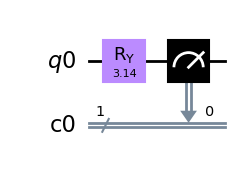

In [29]:
theta = 3.14 

qc.ry(theta,qbit)

qc.measure(qbit, cbit)
qc.draw('mpl')

This gives us the basic gate and measurement application. We apply this multiple times with different values of $\theta$ 

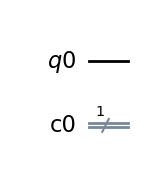

In [30]:
qc = QuantumCircuit(qbit, cbit)
qc.draw('mpl')

In [31]:
n_iter = 200
# range of pi from 3 to 4
rang = [0.1,6.5]
theta = np.linspace(rang[0], rang[1], n_iter)
# list of qtm circuits 
qc_l = []

# all circuits are same with different theta value only
for i in range(n_iter):
    qc_l.append(qc.copy())
    qc_l[i].ry(-theta[i],qbit)
    qc_l[i].measure(qbit, cbit)

We now have 100 seperate circuits with different theta angles, now we simulate these circuits : 

In [32]:
# empty counts list 
counts = []
shot = 10000
for i in range(n_iter):
    job = execute(qc_l[i], backend=simulator, shots= shot)
    counts.append(job.result().get_counts())

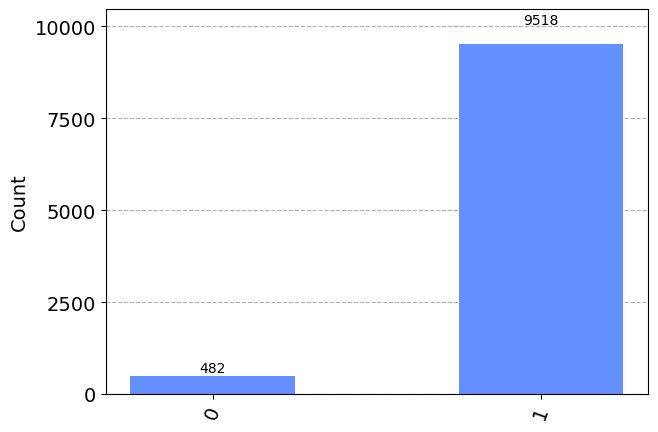

In [33]:
#Plotting a random measurement outcome
plot_histogram(counts[np.random.randint(200)])

Plotting this probability of measuring 1 vs the angle of rotation is : 

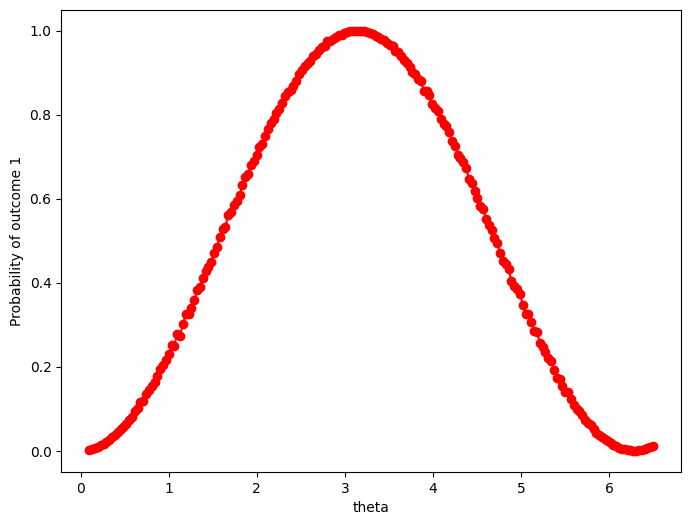

In [34]:
countsOf1 = []
for _ in counts:
    if '1' in _:
        countsOf1.append(_['1']/shot)
    else:
        countsOf1.append(0)

plt.figure(figsize=(8, 6))
plt.plot(theta, countsOf1, 'ro-')
plt.xlabel('theta'); plt.ylabel('Probability of outcome 1')
plt.show()

In [35]:
max_i = countsOf1.index(max(countsOf1))
theta_max = theta[max_i]
print('Maximum probability of 1 occurs at theta (in radians) = ', theta_max)

Maximum probability of 1 occurs at theta (in radians) =  3.1231155778894477


Making the whole thing as a single function so as to iterate it multiple times to get maximum $\theta$ for each iteration 

In [36]:
def CalculatePi(simulator,shots,n,rang,plot) -> list :
    qc_l = []
    counts = []
    countsOf1 = []

    qbit = QuantumRegister(1,name='q0')
    cbit = ClassicalRegister(1,name='c0')
    qc = QuantumCircuit(qbit,cbit)
    theta = np.linspace(rang[0],rang[1],n)
    
    for i in range(n):
        qc_l.append(qc.copy())
        qc_l[i].ry(-theta[i],qbit)
        qc_l[i].measure(qbit, cbit)
    
    for i in range(n):
        job = execute(qc_l[i], backend=simulator, shots= shots)
        counts.append(job.result().get_counts())
    
    for _ in counts:
        if '1' in _:
            countsOf1.append(_['1']/shot)
        else:
            countsOf1.append(0)
    
    max_i = countsOf1.index(max(countsOf1))
    theta_max = theta[max_i]

    if plot:
        plt.figure(figsize=(8, 6))
        plt.plot(theta, countsOf1, 'ro-')
        plt.xlabel('theta')
        plt.ylabel('Probabilidad')
        plt.tight_layout
        plt.show()
        print('maximum angle  ', theta_max)
    
    return theta, countsOf1, theta_max

We now run this function for some iterations get the $\theta$ maximum from all of them then take average and standard deviation for our conclusive data of realised value of $\pi$.

In [37]:
run = 10
pi_s = []
for i in range(run):
    theta, countsOf1, approxpi = CalculatePi(simulator, shots=5000, n=200, rang = [0.1,6.5], plot = False)
    pi_s.append(approxpi)

print('Pi = ', sum(pi_s)/run)
#Desviación típica
print('Standard deviation in values of pi is : ', st.pstdev(pi_s))

Pi =  3.1424120603015075
Standard deviation in values of pi is :  0.015755511913379216


There can be multiple reasons of error in our experiment from the base intial state of qbit being a 100% $|0>$, rotation along y-axis being acurate and then the measurement error. To mitigate these errors the paper transformes the original parameters as a linear combination of another parameter. Basically they did OLS of each parameter along a realised parameter. The probability of getting 1 after rotation by $\theta$ angle is given by 
$$\left|⟨1|e^{-i\sigma_y\frac{\varphi}{2}}|0⟩\right|^2 = \left|⟨1|\cos\left(\frac{\varphi}{2}\right)|0⟩ + ⟨1|\sin\left(\frac{\varphi}{2}\right)|1⟩\right|^2 = \sin^2\left(\frac{\varphi}{2}\right)$$
$$ \sin^2\left(\frac{\varphi}{2}\right)  = \frac {1-\cos(\varphi)}{2}$$
Probability = $ \frac {1-\cos(\theta)}{2} $ but doing OLS on this probability as well as our intial parameter $\theta$ the fitted probability could be given by 
$$ P(t) = \alpha \frac {1-\cos(ct + \phi)}{2} + \beta$$
we make a new function for this fitted probability as :

In [38]:
def P(t,a,b,c,d):
    return a*(1-np.cos(c*t+d))/2 + b

We take a data 

In [50]:
t, countsOf1, approxpi = CalculatePi(simulator, shots=5000, n=200, rang = [0.1,6.5], plot = False)

And fit it to our function to get intiaL values of our OLS variables.

In [51]:
# curve fit function of scipy library taken here with intial guesses of parameters in p0 and bounds in bounds.
ajust = sci.curve_fit( P, t, countsOf1, p0 = [1., 0., 1., 0.], bounds = ( [-1., -1., -3, -np.pi], [2., 1., 3, np.pi] ) )
a, b, c, d = ajust[0]
# the standard deviation ones 
sa, sb, sc, sd = np.sqrt(np.diag(ajust[1]))

print('The realised values using Ordinary least square error are ')
print('a= ', a, ' +- ', sa)
print('b= ', b, ' +- ', sb)
print('c= ', c, ' +- ', sc)
print('d= ', d, ' +- ', sd)

The realised values using Ordinary least square error are 
a=  0.5006106625999344  +-  0.0005097476754505564
b=  -9.63482300136714e-05  +-  0.00046345858530267713
c=  0.9999223355716659  +-  0.0010908717040918868
d=  -0.0008278850659214144  +-  0.0035691216098051697


Plot this realised value w.r.t our plot 

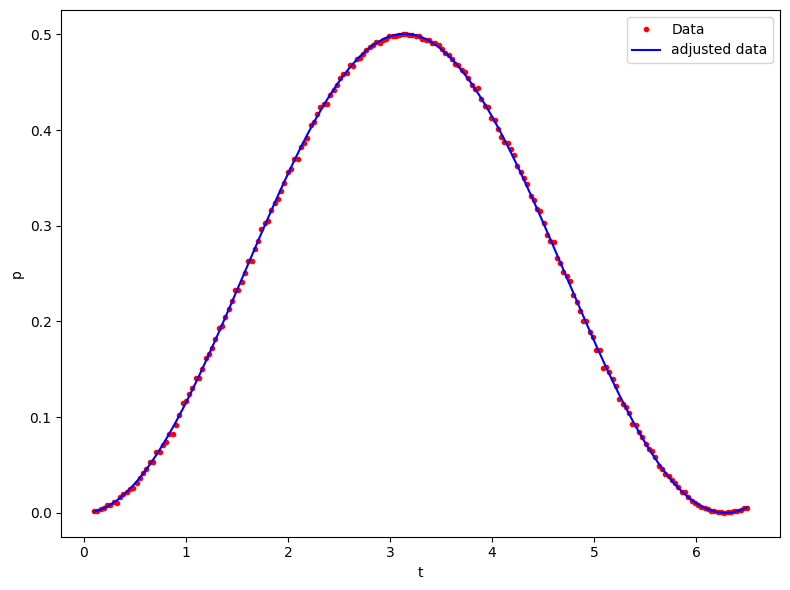

In [52]:
plt.figure(figsize=(8,6))
plt.plot(t, countsOf1, 'r.', label='Data')
plt.plot(t, P(t, a, b, c, d), 'b-', label='adjusted data')
plt.xlabel('t')
plt.ylabel('p')
plt.legend(loc='upper right')
plt.tight_layout() 
plt.show()

getting this equation's 
$$ P(t) = \alpha \frac {1-\cos(ct + \phi)}{2} + \beta$$
the value of fitted $\beta$ and $\alpha$ as 
- $\hat{\beta} = \min_t P(t)$
- $\hat{\alpha} = \max_t P(t) - \hat{\beta}$

In [53]:
bhat = min(countsOf1) 
ahat = max(countsOf1)- bhat
print('beta hat = ', bhat); print('alpha hat = ', ahat)

beta hat =  0
alpha hat =  0.5


Using this data we get the p1($t$) equation as 
$$ p_1(t) = -\bigg (\frac{P(t) - \hat \beta}{\hat \alpha} - \frac 1 2 \bigg) = cos(ct+\phi) $$

In [54]:
p1s = ( np.array(countsOf1) - bhat ) / ahat

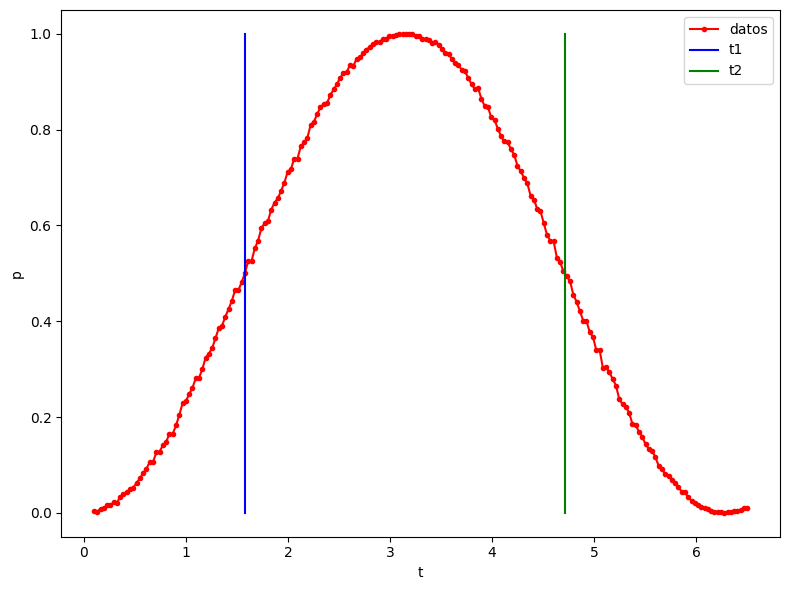

In [55]:
#divide the list in 2 sets from maximum point
t_split = list(p1s).index(max(p1s))
counts21 = p1s[:t_split]
counts22 = p1s[t_split:]
#Interpolate
interp1 = imp(counts21, t[:t_split])
t1 = interp1(0.5)
interp2 = imp(counts22, t[t_split:])
t2 = interp2(0.5)
plt.figure(figsize=(8,6))
plt.plot(t, p1s, 'r.-', label='datos')
plt.plot([t1, t1], [0, 1], 'b-', label='t1')
plt.plot([t2, t2], [0, 1], 'g-', label='t2')
plt.xlabel('t'); plt.ylabel('p')
plt.legend(loc='upper right')
plt.tight_layout(); plt.show()